In [3]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr

import kd_analysis.main.kd_utils as kd
import kd_analysis.main.kd_plotting as kp
import kd_analysis.main.kd_hypno as kh
import kd_analysis.main.kd_pandas as kpd
import kd_analysis.ACR.acr_utils as acu
import sleep_score_for_me.v4 as ssfm
import ipywidgets as wd

# Get All Needed Info

In [9]:
subject = wd.Text(value='', description='Subject:')
subject

Text(value='', description='Subject:')

In [8]:
block_id = wd.Text(value='', description='Block:')
block_id

Text(value='', description='Block:')

In [12]:
eeg_chan = wd.IntText(
    value=1,
    description='EEG-Channel:',
    disabled=False
)
eeg_chan

IntText(value=1, description='EEG-Channel:')

# Score and Plot any Given Day

In [15]:
block_path  = Path('/Volumes/opto_loc/Data/' + subject.value + '/' + subject.value + '-' + block_id.value)

def load_scoring_data(emg_chan=1):
    eeg = kd.get_data(block_path, store='EEGr', channel=[1,2])
    emg = kd.get_data(block_path, store='EMGr', channel = [1,2], sel_chan=emg_chan)
    return eeg, emg

eeg, emg = load_scoring_data()

read from t=0s to t=258011.91s
Using 1017.2526 Hz as SEV sampling rate for EEGr
read from t=0s to t=258011.91s
Using 1017.2526 Hz as SEV sampling rate for EMGr


In [ ]:
def ss(eeg, emg, chan=eeg_chan.value):
    return ssfm.ssfm_v4(eeg, emg, chan)

hypno, fig = ss(eeg, emg)

min = eeg.datetime.values.min()
max = eeg.datetime.values.max()
total_days = np.arange(min.astype('datetime64[D]'), max.astype('datetime64[D]')+ np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
"Range of all loaded data: " + str(min.astype('datetime64[m]')) + "   to   " + str(max.astype('datetime64[m]'))

In [21]:
day = wd.Dropdown(
    options=total_days,
    value=total_days[0],
    description='Day:',
    disabled=False,
)
day

Dropdown(description='Day:', options=(numpy.datetime64('2022-08-05'), numpy.datetime64('2022-08-06'), numpy.da…

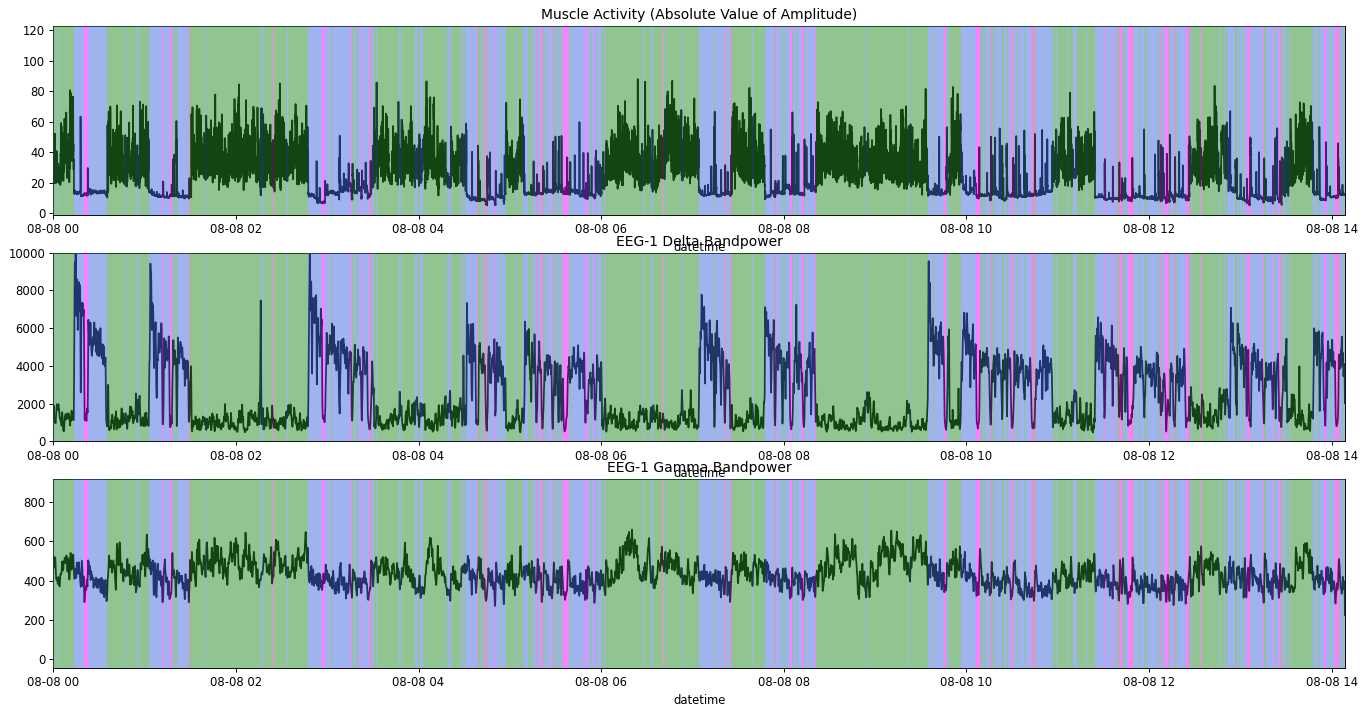

In [80]:
%matplotlib widget
trim_start = day.value
trim_end = day.value + np.timedelta64(24, 'h')

trim_start = min if trim_start < min else trim_start
trim_end = max if trim_end > max else trim_end

fig.axes[0].set_xlim(trim_start, trim_end);
fig.axes[1].set_xlim(trim_start, trim_end);
fig.axes[2].set_xlim(trim_start, trim_end);
fig

# Asleep or Awake Just Before Lights-On?

In [78]:
frac_oc = []
for d in total_days:
    start = pd.Timestamp(str(d) + 'T06:00:00')
    end = pd.Timestamp(str(d) + 'T09:00:00')
    h = hypno[(hypno.end_time >= start) & (hypno.end_time < end)]
    if len(h) > 0:
        time_in_wake = h.fractional_occupancy()['Wake']*100
        frac_oc.append(time_in_wake)
    else:
        frac_oc.append(0)

In [79]:
f, ax = plt.subplots(figsize=(10,6))
plt.scatter(total_days, frac_oc)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …